# Predicting Customer Churn Project

# EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Check the balance of the target variable (Churn)
print(df['Churn'].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


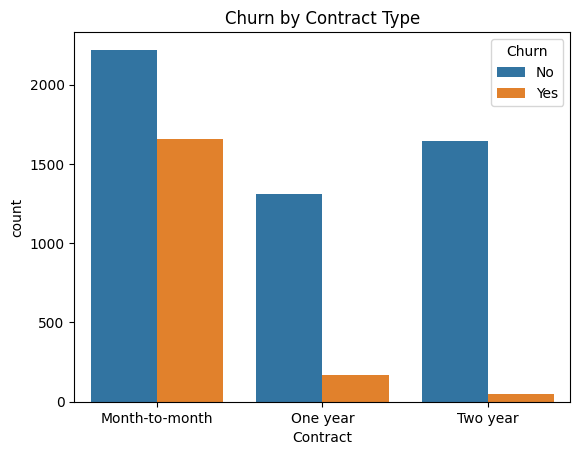

In [7]:

# Churn by Contract Type
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Churn by Contract Type")
plt.show()

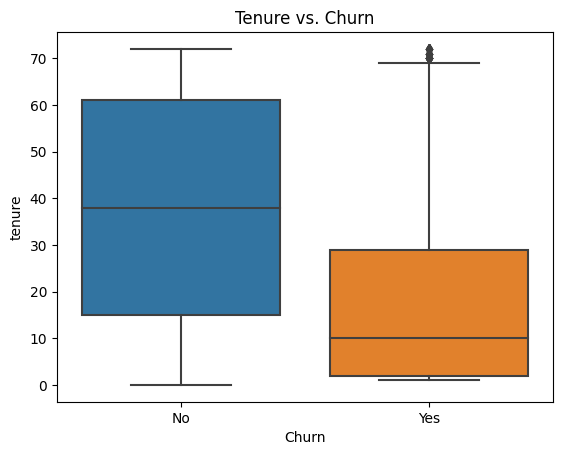

In [8]:
# Is tenure linked to churn?
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title("Tenure vs. Churn")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

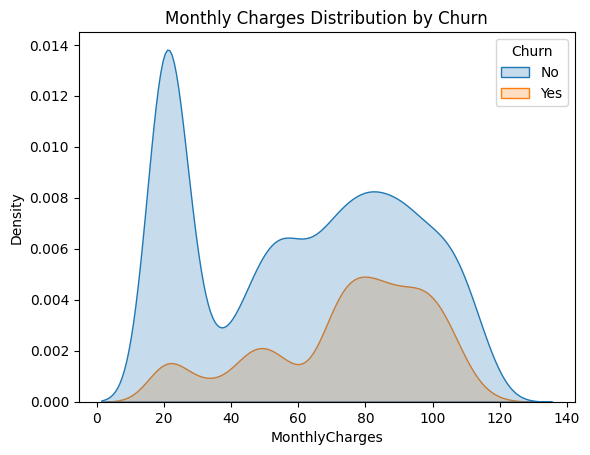

In [9]:
# Affect of monthly charges
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True)
plt.title("Monthly Charges Distribution by Churn")
plt.show()

In [10]:
pd.crosstab(df['InternetService'], df['Churn'], normalize='index')

Churn,No,Yes
InternetService,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
No,0.925950,0.074050


In [11]:
# Handling missing data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipykernel_35/3515487416.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [12]:
# New Feature HighCharge and NewCustomer
df['HighCharge'] = (df['MonthlyCharges'] > 89.85).astype(int)
df['NewCustomer'] = (df['tenure'] < 12).astype(int)

In [13]:
# Split features (X) and target (y)
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn'].map({'Yes': 1, 'No': 0})

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Identify column types
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessor: One-hot encode categoricals and scale numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Modelling

In [20]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, precision_recall_curve, RocCurveDisplay, precision_score
from sklearn.model_selection import learning_curve

In [21]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

In [22]:
# Initialize models with verbosity
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, verbose=1),
    "Gradient Boosting": GradientBoostingClassifier(n_iter_no_change=5, verbose=1, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=3, eval_metric='logloss', verbosity=1)
}



Training Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1552
           1       0.51      0.79      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.76      2113

Recall (Churn=1): 0.79
Precision (Churn=1): 0.51


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

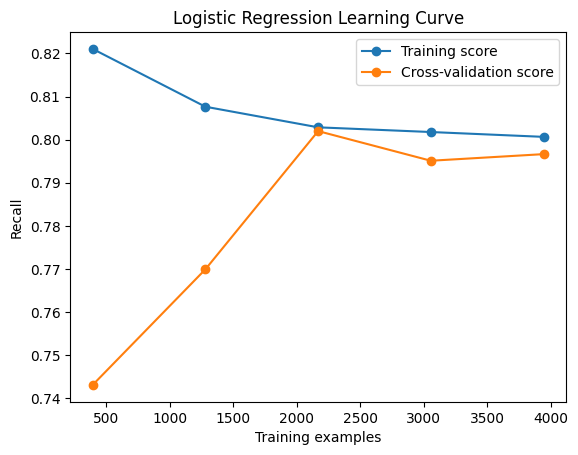

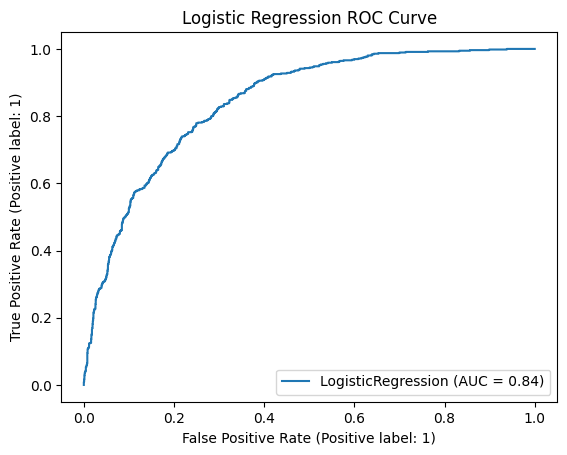


Training Random Forest


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1552
           1       0.61      0.47      0.53       561

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.70      2113
weighted avg       0.77      0.78      0.77      2113

Recall (Churn=1): 0.47
Precision (Churn=1): 0.61


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_j

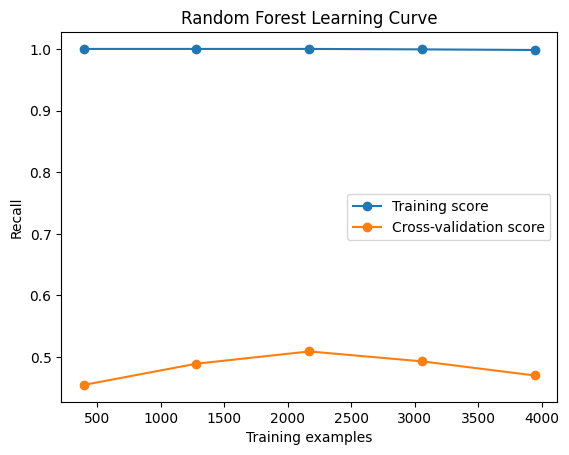

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


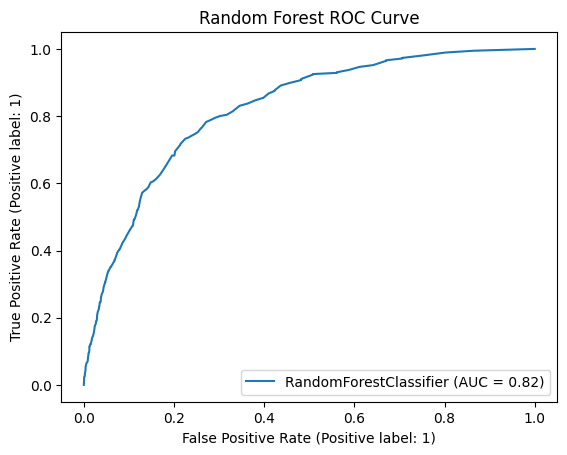

NameError: name 'feature_names' is not defined

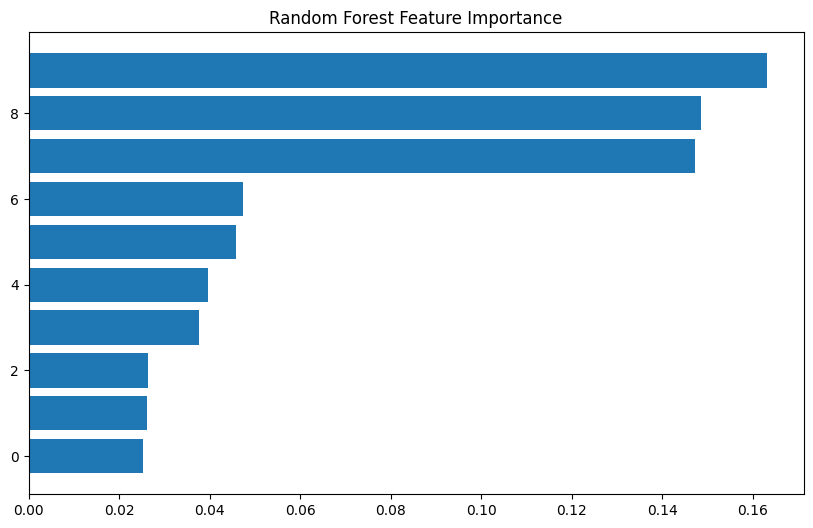

In [23]:
# Train and evaluate with training curves
for name, model in models.items():
    print(f"\n{'='*40}\nTraining {name}\n{'='*40}")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Evaluation
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"Recall (Churn=1): {recall_score(y_test, y_pred, pos_label=1):.2f}")
    print(f"Precision (Churn=1): {precision_score(y_test, y_pred, pos_label=1):.2f}")
    
    # Plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='recall',
        train_sizes=np.linspace(0.1, 1.0, 5), verbose=0)
    
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Recall")
    plt.legend()
    plt.show()
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()
    
    # Feature importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(10,6))
        plt.title(f"{name} Feature Importance")
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.show()

# Additional: Naive baseline comparison
print("\nNaive Model (Always Predict 0)")
print(classification_report(y_test, np.zeros_like(y_test)))